# Case 1 (Part I): House price prediction

In this case (Part I), you will build a multilayer perceptron network to predict the selling price of properties. The dataset consists of all single family houses and condos that were sold in Denver in a given year.

---
## Data Loading and Visualize Data

You first need to read the data using pandas.

In [34]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis

data_path_train = "https://www.dropbox.com/scl/fi/p5wqzhzorpg2a9qq7o2on/train.csv?rlkey=nq3r3wug3ul1j6bylm2njb2dk&dl=1"

train_df = pd.read_csv(data_path_train)

In [35]:
print(train_df)

           ID                          NBHD               PROP_CLASS  \
0      454754                     MONTCLAIR             CONDOMINIUMS   
1      190773                      HIGHLAND  SINGLE FAMILY RESIDENCE   
2      159143                   ATHMAR PARK  SINGLE FAMILY RESIDENCE   
3      110649                     MONTCLAIR  SINGLE FAMILY RESIDENCE   
4      694203  GATEWAY / GREEN VALLEY RANCH  SINGLE FAMILY RESIDENCE   
...       ...                           ...                      ...   
11576    6526                     RUBY HILL  SINGLE FAMILY RESIDENCE   
11577  420264                    UNIVERSITY  SINGLE FAMILY RESIDENCE   
11578  380716                   FIVE POINTS             CONDOMINIUMS   
11579   83737  GATEWAY / GREEN VALLEY RANCH  SINGLE FAMILY RESIDENCE   
11580  441854                SOUTHMOOR PARK  SINGLE FAMILY RESIDENCE   

       LIVING_SQFT  FBSMT_SQFT  BSMT_AREA  LAND_SQFT  GRD_AREA  BLDG_AGE  \
0              928           0          0          0       

### Visualization of SALE PRICES in train data

Let's take a closer look at the sale prices in the train data.

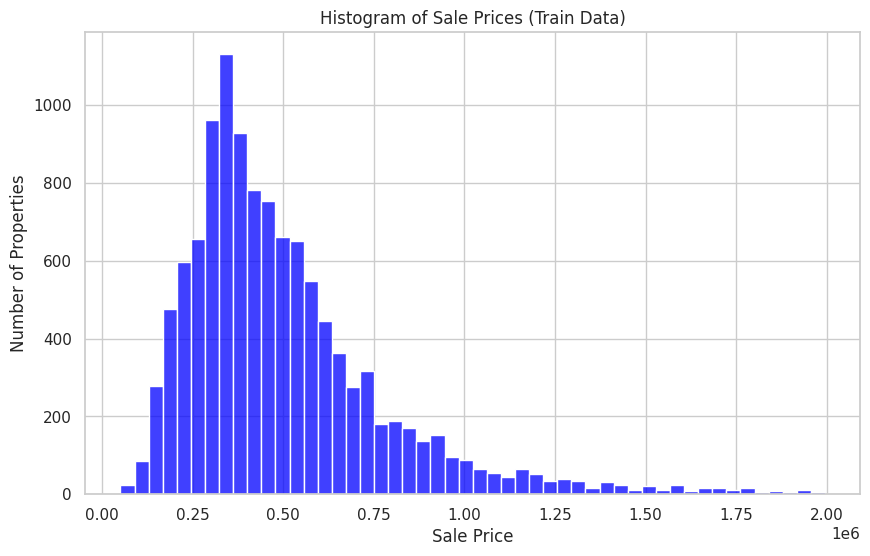

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- **Train labels**: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. **Note**: We need to ensure that the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [37]:
#define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

In [38]:
train_labels.shape

(11581,)

The column ID does not contain any useful information so we drop it from our data file.

In [39]:
train_ID=train_df['ID']
train_df.drop('ID', axis=1, inplace=True)

In [40]:
# find out which are numerical features
numeric_features = train_df.dtypes[train_df.dtypes != 'object'].index
non_numeric_features = train_df.dtypes[train_df.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

In [41]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    train_features= train_df.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    train_features = pd.get_dummies(train_df, columns=non_numeric_features, dummy_na=False)

# Check for non-numeric columns
non_numeric_cols = train_features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [42]:
#impute missing values in numeric features with 0
train_features[numeric_features]=train_features[numeric_features].fillna(0)

In [43]:
train_features.shape

(11581, 102)

In [44]:
#standardize the features

import numpy as np
train_mu = train_features.mean()
train_sd = train_features.std()



In [45]:
train_features_std=((train_features - train_mu)/(train_sd))

#drop columns with NA values
train_features_std=train_features_std.dropna(axis='columns')

In [46]:
# check whether there is any missing entry; we ended up with 102 variables
print(train_features_std.isnull().sum())

LIVING_SQFT               0
FBSMT_SQFT                0
BSMT_AREA                 0
LAND_SQFT                 0
GRD_AREA                  0
                         ..
STYLE_CN_MIDDLE UNIT      0
STYLE_CN_RANCH            0
STYLE_CN_SPLIT LEVEL      0
STYLE_CN_TRI-LEVEL        0
STYLE_CN_TRI-LEVEL W/B    0
Length: 102, dtype: int64


---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [47]:
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set
# Splitting the training data: 20% is validation data
train_indices, valid_indices, train_features, valid_features, train_labels, valid_labels = train_test_split(
    np.arange(len(train_labels)),
    train_features_std,
    train_labels,
    test_size=0.2,
    random_state=42
)

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model.

We need to think about what loss function and what metric for evaluating predictive performance to use.

*  We will be using the mean absolute error loss for training loss.
*  We will use a different metric to measure the predictive performance.


Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we error by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

In [48]:
# we need to define our own error rate function.

import tensorflow as tf
import tensorflow_probability as tfp

def median_error_rate(y_true, y_pred):
 # Calculate the absolute percentage error
    absolute_percentage_error = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true),
                                                                            tf.keras.backend.epsilon(),
                                                                            tf.float32.max))
    # Return the median of these errors
    return tfp.stats.percentile(absolute_percentage_error, 50.0)  # Use 50th percentile for median


In [68]:
#TODO: Build a multi-layer perception neural network with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations
import keras

p = train_features_std.shape[1]
print(p)

#build the MLP
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(256, input_shape=(p,), activation="ReLU"))
model1.add(keras.layers.Dense(128, activation="ReLU"))
model1.add(keras.layers.Dense(1, activation="linear"))

## display the model's architecture
model1.summary()

## compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
               loss="mae",
               metrics=[median_error_rate]
               )

102
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 256)               26368     
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 59393 (232.00 KB)
Trainable params: 59393 (232.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
#TODO: write code to train the MLP network

# Compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
               loss="mae", metrics=[median_error_rate])

# Train the model
history1 = model1.fit(train_features,
                      train_labels,
                      epochs=50,
                      validation_data=(valid_features, valid_labels),
                      batch_size=32,
                      verbose=1)

Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 1.1268 - median_error_rate: 0.1750 - val_loss: 0.9840 - val_median_error_rate: 0.1393
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.9424 - median_error_rate: 0.1399 - val_loss: 0.9495 - val_median_error_rate: 0.1415
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.8538 - median_error_rate: 0.1194 - val_loss: 0.8766 - val_median_error_rate: 0.1218
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.8458 - median_error_rate: 0.1196 - val_loss: 0.8479 - val_median_error_rate: 0.1145
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.8216 - median_error_rate: 0.1145 - val_loss: 0.8904 - val_median_error_rate: 0.1209
Epoch 6/50
290/290 [==============================] - 2s 6ms/step - loss: 0.7942 - median_error_rate: 0.1080 - val_loss: 0.8562 - val_median_error_rate: 0.1201
Epoch 7/50
290/290 [====================

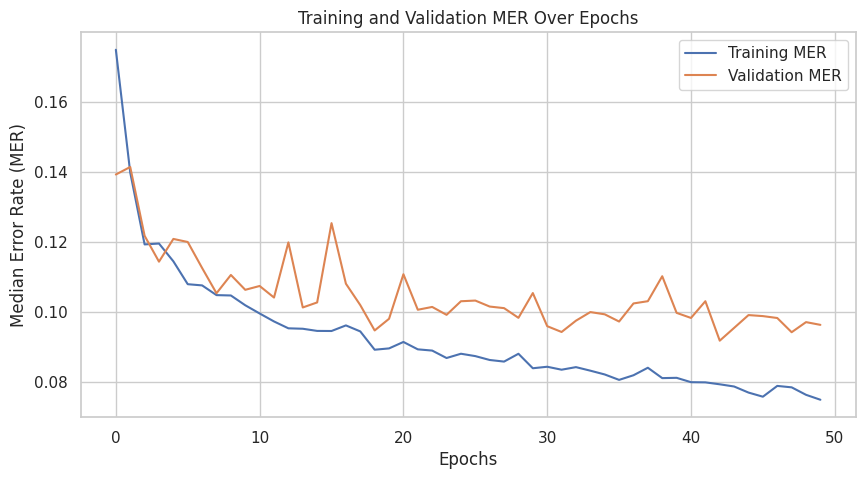

In [85]:
#TODO: Write code to plot the training error (MER) over epochs
plt.figure(figsize=(10, 5))
plt.plot(history1.history['median_error_rate'], label='Training MER')
plt.plot(history1.history['val_median_error_rate'], label='Validation MER')
plt.title('Training and Validation MER Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Median Error Rate (MER)')
plt.legend()
plt.show()

**Question 1**: What are your final training and validation errors of the multilayer perception model?


In [76]:
# Access the history dictionary
history_dict = history1.history

# Retrieve the last values of the median error rate for training and validation
final_training_median_error_rate = history_dict['median_error_rate'][-1]
final_validation_median_error_rate = history_dict['val_median_error_rate'][-1]

# Print the results
print(f"Final Training Median Error Rate: {final_training_median_error_rate}")
print(f"Final Validation Median Error Rate: {final_validation_median_error_rate}")

Final Training Median Error Rate: 0.07501682639122009
Final Validation Median Error Rate: 0.09640426188707352


**Now change the model structure**

In [81]:
#TODO: Build a multi-layer perception neural network with 4 hidden layers of sizes 512, 256, 128 and 64, respectively and ReLu activations
import keras

p = train_features_std.shape[1]
print(p)

#build the MLP
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(512, input_shape=(p,), activation="ReLU"))
model2.add(keras.layers.Dense(256, activation="ReLU"))
model2.add(keras.layers.Dense(128, activation="ReLU"))
model2.add(keras.layers.Dense(64, activation="ReLU"))
model2.add(keras.layers.Dense(1, activation="linear"))

## display the model's architecture
model2.summary()

102
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 512)               52736     
                                                                 
 dense_60 (Dense)            (None, 256)               131328    
                                                                 
 dense_61 (Dense)            (None, 128)               32896     
                                                                 
 dense_62 (Dense)            (None, 64)                8256      
                                                                 
 dense_63 (Dense)            (None, 1)                 65        
                                                                 
Total params: 225281 (880.00 KB)
Trainable params: 225281 (880.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
#TODO: write code to train the MLP network
# Compile the model
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
               loss="mae",
               metrics=[median_error_rate])

# Train the model
history2 = model2.fit(train_features,
                      train_labels,
                      epochs=50,
                      validation_data=(valid_features, valid_labels),
                      batch_size=32,
                      verbose=1)

Epoch 1/50
290/290 [==============================] - 8s 12ms/step - loss: 1.1635 - median_error_rate: 0.1812 - val_loss: 0.9504 - val_median_error_rate: 0.1355
Epoch 2/50
290/290 [==============================] - 3s 9ms/step - loss: 0.9449 - median_error_rate: 0.1385 - val_loss: 0.9016 - val_median_error_rate: 0.1212
Epoch 3/50
290/290 [==============================] - 3s 11ms/step - loss: 0.8843 - median_error_rate: 0.1240 - val_loss: 0.8564 - val_median_error_rate: 0.1141
Epoch 4/50
290/290 [==============================] - 3s 11ms/step - loss: 0.8546 - median_error_rate: 0.1203 - val_loss: 0.8566 - val_median_error_rate: 0.1150
Epoch 5/50
290/290 [==============================] - 2s 8ms/step - loss: 0.8323 - median_error_rate: 0.1159 - val_loss: 0.8298 - val_median_error_rate: 0.1096
Epoch 6/50
290/290 [==============================] - 2s 8ms/step - loss: 0.8070 - median_error_rate: 0.1090 - val_loss: 0.8317 - val_median_error_rate: 0.1133
Epoch 7/50
290/290 [=================

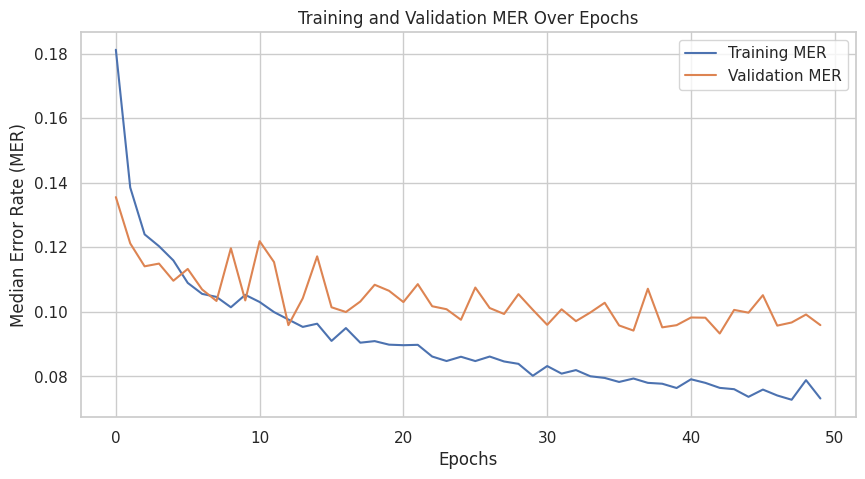

In [86]:
#TODO: Write code to plot the training error (MER) over epochs
plt.figure(figsize=(10, 5))
plt.plot(history2.history['median_error_rate'], label='Training MER')
plt.plot(history2.history['val_median_error_rate'], label='Validation MER')
plt.title('Training and Validation MER Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Median Error Rate (MER)')
plt.legend()
plt.show()


**Question 2**: What are your final training and validation errors of the second multilayer perception model?

In [94]:
# Access the history dictionary
history_dict = history2.history

# Retrieve the last values of the median error rate for training and validation
final_training_median_error_rate = history_dict['median_error_rate'][-1]
final_validation_median_error_rate = history_dict['val_median_error_rate'][-1]

# Print the results
print(f"Final Training Median Error Rate: {round(final_training_median_error_rate*100, 5)}%")
print(f"Final Validation Median Error Rate: {round(final_validation_median_error_rate*100, 5)}%")

Final Training Median Error Rate: 7.31727%
Final Validation Median Error Rate: 9.58977%


**Now a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64 and drop out**

In [95]:
#TODO: Build a multi-layer perception neural network with 4 hidden layers of sizes 512, 256, 128 and 64, respectively and ReLu activations
import keras

p = train_features_std.shape[1]
print(p)

#build the MLP
model3 = keras.models.Sequential()
model3.add(keras.layers.Dense(512, input_shape=(p,), activation="ReLU"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(256, activation="ReLU"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(128, activation="ReLU"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(64, activation="ReLU"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(1, activation="linear"))

## display the model's architecture
model3.summary()

102
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 512)               52736     
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_65 (Dense)            (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_66 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_67 (Dense)            (None, 64)          

In [ ]:
#TODO: write code to train the MLP network
# Compile the model
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
               loss="mae", metrics=[median_error_rate])

# Train the model
history3 = model3.fit(train_features,
                      train_labels,
                      epochs=50,
                      validation_data=(valid_features, valid_labels),
                      batch_size=32,
                      verbose=1)

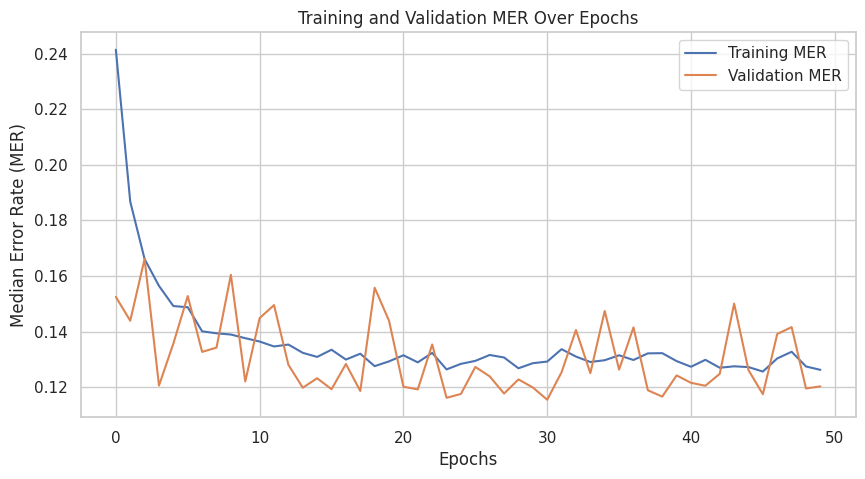

In [98]:
#TODO: Write code to plot the training error (MER) over epochs
plt.figure(figsize=(10, 5))
plt.plot(history3.history['median_error_rate'], label='Training MER')
plt.plot(history3.history['val_median_error_rate'], label='Validation MER')
plt.title('Training and Validation MER Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Median Error Rate (MER)')
plt.legend()
plt.show()

**Question 3**: What are your final training and validation errors of the third multilayer perception model?

In [111]:
# Access the history dictionary
history_dict = history3.history

# Retrieve the last values of the median error rate for training and validation
final_training_median_error_rate = history_dict['median_error_rate'][-1]
final_validation_median_error_rate = history_dict['val_median_error_rate'][-1]

# Print the results
print(f"Final Training Median Error Rate: {round(final_training_median_error_rate*100, 5)}%")
print(f"Final Validation Median Error Rate: {round(final_validation_median_error_rate*100, 5)}%")

Final Training Median Error Rate: 8.85413%
Final Validation Median Error Rate: 9.71031%


In [115]:

min(history_dict['val_median_error_rate'])

0.09239575266838074

---
## Predict with the best model.

Modify the python code we used in class to
use the ModelCheckpoint callback to save the best model parameter values while training model 3 above. Then predict with this best model.  

In [ ]:
activation_list = ['relu']
learning_rate_list = [0.001, 0.005, 0.01]
dropout_rate_list = [0.1, 0.2, 0.3]

result_list = []

checkpoint_dir = "checkpoints"

import os

try:
    os.mkdir(checkpoint_dir)
except:
    pass

filename = "weights-best-model.hdf5"
filepath = os.path.join(checkpoint_dir, filename)
checkpointer = keras.callbacks.ModelCheckpoint(filepath,
                                              monitor='val_median_error_rate',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='auto')

for activation in activation_list:
  for learning_rate in learning_rate_list:
    for dropout_rate in dropout_rate_list:
      model3 = keras.models.Sequential()
      model3.add(keras.layers.Dense(512, input_shape=(p,), activation=activation))
      model3.add(keras.layers.Dropout(dropout_rate))
      model3.add(keras.layers.Dense(256, activation=activation))
      model3.add(keras.layers.Dropout(dropout_rate))
      model3.add(keras.layers.Dense(128, activation=activation))
      model3.add(keras.layers.Dropout(dropout_rate))
      model3.add(keras.layers.Dense(64, activation=activation))
      model3.add(keras.layers.Dropout(dropout_rate))
      model3.add(keras.layers.Dense(1, activation='linear'))

      model3.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                     loss="mae",
                     metrics=[median_error_rate])

      history3 = model3.fit(train_features,
                            train_labels,
                            epochs=50,
                            validation_data=(valid_features, valid_labels),
                            batch_size=32,
                            verbose=1,
                            callbacks=[checkpointer])

      history3_dict = history3.history

      result_list.append([activation, learning_rate, dropout_rate, min(history3_dict['val_median_error_rate'])])


Epoch 1/50
286/290 [============================>.] - ETA: 0s - loss: 1.2443 - median_error_rate: 0.1994
Epoch 1: val_median_error_rate improved from inf to 0.13743, saving model to checkpoints/weights-best-model.hdf5
290/290 [==============================] - 5s 11ms/step - loss: 1.2402 - median_error_rate: 0.1991 - val_loss: 0.9612 - val_median_error_rate: 0.1374
Epoch 2/50
 14/290 [>.............................] - ETA: 2s - loss: 1.0776 - median_error_rate: 0.1655

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/290 [============================>.] - ETA: 0s - loss: 1.0250 - median_error_rate: 0.1576
Epoch 2: val_median_error_rate improved from 0.13743 to 0.13245, saving model to checkpoints/weights-best-model.hdf5
290/290 [==============================] - 3s 9ms/step - loss: 1.0228 - median_error_rate: 0.1575 - val_loss: 0.9041 - val_median_error_rate: 0.1324
Epoch 3/50
290/290 [==============================] - ETA: 0s - loss: 0.9719 - median_error_rate: 0.1488
Epoch 3: val_median_error_rate improved from 0.13245 to 0.11483, saving model to checkpoints/weights-best-model.hdf5
290/290 [==============================] - 3s 9ms/step - loss: 0.9719 - median_error_rate: 0.1488 - val_loss: 0.8461 - val_median_error_rate: 0.1148
Epoch 4/50
287/290 [============================>.] - ETA: 0s - loss: 0.9322 - median_error_rate: 0.1388
Epoch 4: val_median_error_rate did not improve from 0.11483
290/290 [==============================] - 3s 11ms/step - loss: 0.9313 - median_error_rate: 0.1387 - val

In [150]:
df_result = pd.DataFrame(result_list, columns = ['activation_func', 'learning_rate', 'dropout_rate', 'best_val_median_error_rate'])
df_result

,activation_func,learning_rate,dropout_rate,best_val_median_error_rate
0,relu,0.001,0.1,0.092734


---
## Inference on validation data

After the MLP model is trained, we can use it for inference.

In [151]:
## load the saved weights for the best model

## evaluation using the last weights
score = model3.evaluate(valid_features, valid_labels)
print(score)

## load the saved weights for the best model
checkpoints = os.listdir(checkpoint_dir)
print(checkpoints)
model3.load_weights(os.path.join(checkpoint_dir, "weights-best-model.hdf5"))

## evaluation on the test data using loaded weights
score=model3.evaluate(valid_features, valid_labels)
print(score)

73/73 [==============================] - 0s 4ms/step - loss: 0.7867 - median_error_rate: 0.1059
[0.7867184281349182, 0.10586728155612946]
['weights-best-model.hdf5']
73/73 [==============================] - 0s 4ms/step - loss: 0.7243 - median_error_rate: 0.0927
[0.7242770195007324, 0.09273387491703033]


Let's first compute the predicted prices on the valid data. Remember when predict the price, we need to multiply back the normalization factor.

In [152]:
#To do: calculate the predicted values on the validation data set

valid_labels_pred_norm=model3.predict(valid_features)
valid_labels_pred=valid_labels_pred_norm*normalization_factor
v_labels=valid_labels*normalization_factor

73/73 [==============================] - 0s 2ms/step


In [153]:
valid_labels_pred

array([[586438.17901611],
       [549100.78048706],
       [275626.80244446],
       ...,
       [623009.39559937],
       [520143.89038086],
       [280535.45951843]])

Then we compute the validation errors using the error measure "median_error_rate" we defined. Output the median error rate on validation data.

In [154]:
#To do: calculate the median error rate on validation data. Please use the "median_error_rate" we defined previously.

v_labels_tensor = tf.convert_to_tensor(v_labels.values)
valid_labels_pred_tensor = tf.convert_to_tensor(valid_labels_pred.T[0])
print('Median Error Rate on Validation Data:', median_error_rate(v_labels_tensor, valid_labels_pred_tensor).numpy()*100,'%')

Median Error Rate on Validation Data: 8.902953391851382 %


In [158]:
# from validation data

margin = 0.015

profit_actual = round(sum(v_labels)*margin, 2)
profit_predicted = round(sum(valid_labels_pred)[0]*margin, 2)

print(f' Potential profit from actual price : ${profit_actual}')
print(f' Potential profit from predicted price : ${profit_predicted}\n')
print(f' Potential profit gain/loss against actual market price : ${round(profit_predicted - profit_actual, 2)}')
print(f' % Potential profit gain/loss against actual market price : {round(profit_predicted/profit_actual-1, 2)*100}%')

 Potential profit from actual price : $17548216.96
 Potential profit from predicted price : $17147742.64

 Potential profit gain/loss against actual market price : $-400474.32
 % Potential profit gain/loss against actual market price : -2.0%
